# Assignment 1: Life-Cycle Labor Supply with Children

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

figpath = r"/Users/bruger/Desktop/Household behavior/HouseholdBehaviorCourse-3/05/Figures"

In [2]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':0}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Give names to simulations
cons = 'c'
hours = 'h'
kids = 'n'
assets = 'a'
capital = 'k'
spouse = 's'

# Question 1
In the following of code, I solve and simulate the model for a different number of beta_1 values. 

1.1) I calculate mean optimal hours in time relevant to brith and save these for each of the beta_1 values. 

1.2) I plot the mean values. 

In [4]:
# 1.1) Solve and simulate model for multiple values of beta (eye ball econometrics)
beta_1_list = [0.01, 0.02, 0.03, 0.04, 0.05]
m_hours_b = {}

for beta_1 in beta_1_list:
    model.par.beta_1 = beta_1
    model.solve()
    model.simulate()

    birth = np.zeros(sim.n.shape,dtype=np.int_)
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0 #G enerates an 1D-array array where 1-values indicate that a birth occurred between two periods 
    
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * birth, axis=1)
    
    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))
    
    time_since_birth = periods - time_of_birth

    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # relative to period before birth
    event_hours_rel = event_hours - event_hours[event_grid==-1]

    m_hours_b[beta_1] = event_hours
    m_hours_b[(beta_1, 'rel')] = event_hours_rel

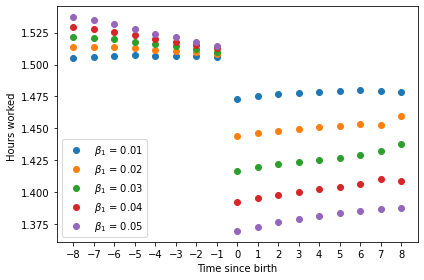

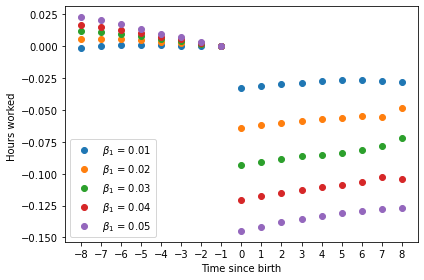

In [5]:
# 1.2) Event study plots 
fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1)],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/beta1.pdf",edgecolor='k')

fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1),'rel'],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/betarel1.pdf",edgecolor='k')

# Question 2
a) Calculate Marshallian elasticity (ela_M). I do the following steps:

2.1) I run a loop in which I solve the the model for tau=0.1(baseline) and tau=0.101 (new).
   I save average hours worked over the time period under both regimes.
   This allows me to compare hours worked under the initial regime where the income tax is 10 pct. with the new regime where the income tax i 11 pct.

2.2) I calculate the Marshallian elasticity by subtracting mean hours under old regime from mean hours under new regime and dividing by hours under old regime. This provides the pct. change in average hours for each time period following a 1 pct. increase in the marginal tax. 

2.3) I plot the Marshallian elasticity over the time period. 


In [6]:
# 2.1) Solve model for tau = 0.1 (baseline) and tau=0.11 
tau_list = [0.1,0.101]
m_hours = np.zeros((len(tau_list), par.simT))

for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.beta_1 = 0.03
    model.par.phi = 0. # no spouse income
    model.par.theta = 0. #no child cost 
    model.solve()
    model.simulate()
    m_hours[i] = np.mean(getattr(sim,hours),axis=0).tolist()

In [7]:
# 2.2) Calculate Marshallian elasticity
ela_M = ((m_hours[1]- m_hours[0])/m_hours[0])*100

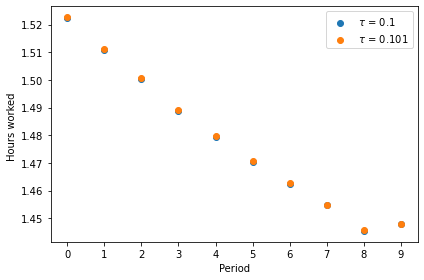

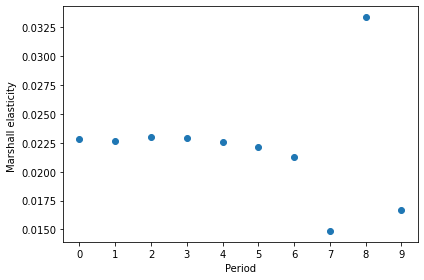

In [8]:
# 2.3) Plot hours worked for tau=0.10 and tau=0.11 and Marshall elasticity
periods = np.arange(0, par.T)
fig, ax = plt.subplots()
for i, tau in enumerate(tau_list):
    ax.scatter(periods,m_hours[i],label=fr"$\tau$ = {tau}")
ax.set(xlabel='Period',ylabel=f'Hours worked ',xticks=periods)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/hours_2(1).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods,ela_M)
ax.set(xlabel='Period',ylabel=f'Marshall elasticity ',xticks=periods);
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_2(1).pdf",edgecolor='k')

b) Determine Marshallian elasticity for individuals with and without children. 

2.4) I run a loop in which I solve the model under the two tax regimes, conditional on whether there is a child present. 
First, I back out hours for individuals with and without children in each period. 
Second, I calculate average hours for individuals with and without children in each period. 

2.5) I take out period 0 as individuals do not have children in period 0. 

2.6) I calcilate the elasticities conditional on having children. As before I by subtract mean hours under old regime from mean hours under new regime and dividing by hours under old regime. This provides the pct. change in average hours for each time period following a 1 pct. increase in the marginal tax. 

2.7) I plot hours worked and Marshallian elasticityover the time period for persons with children and without children. 
I consider only period 1-9 as there are no individuals who have children in period 0. 


In [9]:
# 2.4) Run model for two tax regimes
tau_list = [0.1,0.101]

m_hours_c0 = np.empty((len(tau_list), par.simT))
m_hours_c1 = np.empty((len(tau_list), par.simT))

for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.beta_1 = 0.03
    model.par.phi = 0.
    model.par.theta = 0.
    model.solve()
    model.simulate()

    for t in range(par.simT):
        hours_c0_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 0, t]  # extract hours for c=0 for period t
        hours_c1_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 1, t]  # extract hours for c=1 for period t
        m_hours_c0[i, t] = np.mean(hours_c0_t) if hours_c0_t.size else None  # calculate mean hours for c=0 in current period t and assign to array
        m_hours_c1[i, t] = np.mean(hours_c1_t) if hours_c1_t.size else None  # calculate mean hours for c=1 in current period t and assign to array

In [10]:
# 2.5) take out first obs
m_hours_c0_n = m_hours_c0[:,1:]
m_hours_c1_n = m_hours_c1[:,1:]

In [11]:
#2.6) elasticities
ela_M_c0 = ((m_hours_c0_n[1]- m_hours_c0_n[0])/m_hours_c0_n[0])*100
ela_M_c1 = ((m_hours_c1_n[1]- m_hours_c1_n[0])/m_hours_c1_n[0])*100

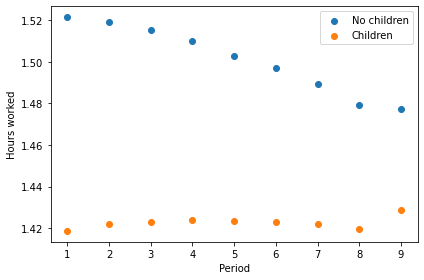

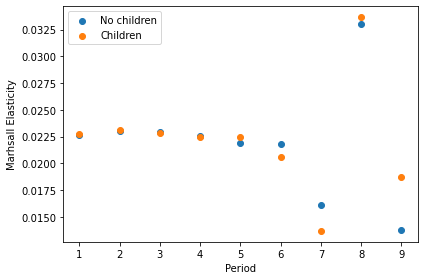

In [12]:
# 2.7) Plot hours worked and marshall elasticity for individuals without and with children 
periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c0_n[0], label='No children')
ax.scatter(periods, m_hours_c1_n[0], label='Children')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_2(2).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c0, label='No children')
ax.scatter(periods, ela_M_c1, label='Children')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_2(2).pdf",edgecolor='k')

# Question 3
I have added parameters par.phi = 0 and in the py-fle. I call this when I want to solve the model with a spouse. I define an income function that includes spousal income when par.phi is turned on. I call this function in both cons_last and value_of_choice. 
I also add par.theta*kids to hours_min as child costs are now part of the lower bound for how many hours needs to be worked.

In the run the model for values of par.phi = [0,1] and par.theta = [0,0.05] and the two $\tau$-values to determine elasticities. 

3.1) Solve and simulate model for individuals with and without spouse, under the new and old tax regime

3.2) Calculate marshall elasticity for individuals without and with a spouse

3.3) Plot hours worked and Marshall elasticity for individuals without and with spouse 

In [13]:
# 3.1) Solve and simulate model
s_list = [0., 1.]
tau_list = [0.1, 0.101]
m_hours_s = np.zeros((len(s_list), len(tau_list),par.simT))

for i, s in enumerate(s_list):
    m_hours_tau = np.zeros((len(tau_list),par.simT))
    model.par.phi = s
    model.par.theta = 0.
    model.par.beta_1 = 0.03

    for j, tau in enumerate(tau_list):
        model.par.tau = tau
        model.solve()
        model.simulate()
        m_hours_tau[j] = np.mean(getattr(sim, hours), axis=0)
    
    m_hours_s[i] = m_hours_tau

In [14]:
# 3.2) Calculate Marshallian elasticity
ela_M_s0 = ((m_hours_s[0,1] - m_hours_s[0,0])/  m_hours_s[0,0])*100
ela_M_s1 = ((m_hours_s[1,1] - m_hours_s[1,0])/  m_hours_s[1,0])*100

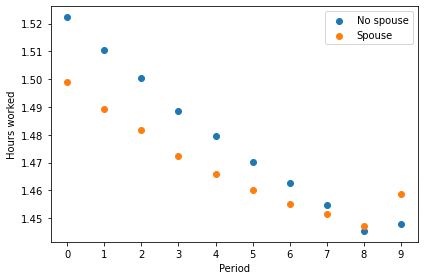

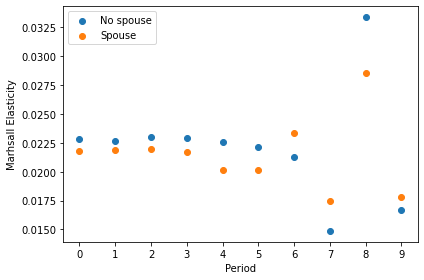

In [15]:
# 3.3) Plot hours worked and Marshall elasticity for individuals without and with spouse 

periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_s[0,0], label='No spouse')
ax.scatter(periods, m_hours_s[1,0], label='Spouse')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_3.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_s0, label='No spouse')
ax.scatter(periods, ela_M_s1, label='Spouse')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_3.pdf",edgecolor='k')

# Question 4
I have added parameter par.theta = 0 and in the py-fle. I call this when I want to solve the model with a child costs. I include child costs in the income function when par.theta is turned on. I call this function in both cons_last and value_of_choice. 
I also add par.theta*kids to hours_min as child costs are now part of the lower bound for how many hours needs to be worked.

In the run the model for values of par.theta = [0,0.05] and the two $\tau$-values to determine elasticities. 

4.1) Solve and simulate model for individuals with and without child costs, under the new and old tax regime

4.2) Calculate marshall elasticity for individuals facing and not facing child costs 

4.3) Plot hours worked and Marshall elasticity for individuals facing child costs

In [16]:
# 4.1) Run model with child care costs for two tax regimes and for individuals with and without kids
tau_list = [0.1,0.101]

m_hours_c0cc = np.empty((len(tau_list), par.simT))
m_hours_c1cc = np.empty((len(tau_list), par.simT))

for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.beta_1 = 0.03
    model.par.phi = 0.
    model.par.theta = 0.05
    model.solve()
    model.simulate()

    for t in range(par.simT):
        hours_c0cc_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 0, t]  # extract hours for c=0 for period t
        hours_c1cc_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 1, t]  # extract hours for c=1 for period t
        m_hours_c0cc[i, t] = np.mean(hours_c0cc_t) if hours_c0cc_t.size else None  # calculate mean hours for c=0 in current period t and assign to array
        m_hours_c1cc[i, t] = np.mean(hours_c1cc_t) if hours_c1cc_t.size else None  # calculate mean hours for c=1 in current period t and assign to array

In [17]:
# 4.2) take out first obs
m_hours_c0cc_n = m_hours_c0cc[:,1:]
m_hours_c1cc_n = m_hours_c1cc[:,1:]

In [18]:
#4.3) elasticities
ela_M_c0cc = ((m_hours_c0cc_n[1]- m_hours_c0cc_n[0])/m_hours_c0cc_n[0])*100
ela_M_c1cc = ((m_hours_c1cc_n[1]- m_hours_c1cc_n[0])/m_hours_c1cc_n[0])*100

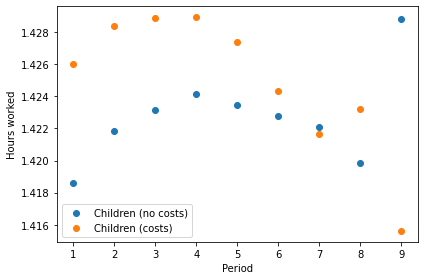

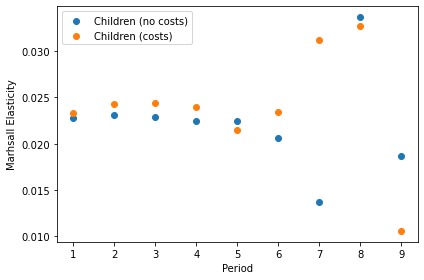

In [19]:
# 4.3) Plot hours worked and Marshall elasticity in model with and without child costs 
periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c1_n[0], label='Children (no costs)')
ax.scatter(periods, m_hours_c1cc_n[0], label='Children (costs)')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_4.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c1, label='Children (no costs)')
ax.scatter(periods, ela_M_c1cc, label='Children (costs)')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_4.pdf",edgecolor='k')

# Question 6

I have added a state variable i_s in the py-file. I call this when I want to solve the model with a stochastic spouse. In all previous models, the state variable simply takes the values 1 at all times. That is; there is always a spouse in the model, but par.phi = 0 so that spouse contributes with zero income. When solving the model with a stochastic spouse, I write up the conditional probabilities of having a child in the next period and having a spouse. THe expected value function of later periods depend on these probabilities. See math in pdf-file. 

I also add par.phi $\cdot$ spouse $\cdot$ (0.1+0.01) to hours_min as spousal income now lowers the lower bound for how many hours needs to be worked in order to satisfy minimum consumption. 

6.1) I solve and simulate the baseline model where par.stoch_s = 0, par.phi = 0 and par.theta = 0.

6.2) I save mean hours worked, consumption, assets and kids 

6.3) I solve and simulate the new model where par.stoch_s = 1, par.phi = 1 and par.theta = 0.05.

6.4) I save mean hours worked, consumption, assets and kids 

6.5) Solve stochastic spouse model under new and old tax regime

6.6) Calculate Marshallian elasticity in new model

6.7) Plot all four variables for the two models


In [20]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model1 = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':0}) # set a few number of periods.

par = model1.par
sol = model1.sol
sim = model1.sim

In [21]:
# 6.1) Solve and simulate baseline model 
model1.solve()
model1.simulate()

In [22]:
# 6.2) Save variables
model1_hours = np.mean(getattr(sim, hours), axis=0).tolist()
model1_cons = np.mean(getattr(sim, cons), axis=0).tolist()
model1_assets = np.mean(getattr(sim, assets), axis=0).tolist()
model1_kids  = np.mean(getattr(sim, kids), axis=0).tolist()
model1_spouse  = np.mean(getattr(sim, spouse), axis=0).tolist()

In [23]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model2 = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':1}) # set a few number of periods.

par = model2.par
sol = model2.sol
sim = model2.sim

In [24]:
# 6.3) Solve and simulate new model
model2.solve()
model2.simulate()

In [25]:
# 6.4) Save variables
model2_hours = np.mean(getattr(sim, hours), axis=0).tolist()
model2_cons = np.mean(getattr(sim, cons), axis=0).tolist()
model2_assets = np.mean(getattr(sim, assets), axis=0).tolist()
model2_kids  = np.mean(getattr(sim, kids), axis=0).tolist()
model2_spouse  = np.mean(getattr(sim, spouse), axis=0).tolist()

In [26]:
# 6.5) Solve stochastic spouse model for tau = 0.1 (baseline) and tau=0.101
tau_list = [0.1,0.101]
m_hours_ss = np.zeros((len(tau_list), par.simT))

for i, tau in enumerate(tau_list):
    model2.par.tau = tau
    model2.par.beta_1 = 0.03
    model2.par.phi = 1. # no spouse income
    model2.par.theta = 0.05 #no child cost 
    model2.solve()
    model2.simulate()
    m_hours_ss[i] = np.mean(getattr(sim,hours),axis=0).tolist()

In [27]:
# 6.6) Calculate Marshallian elasticity
ela_M_ss = ((m_hours_ss[1]- m_hours_ss[0])/m_hours_ss[0])*100

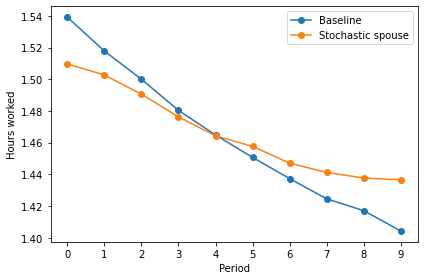

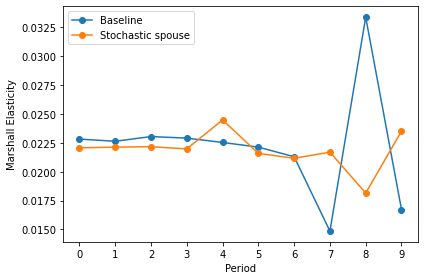

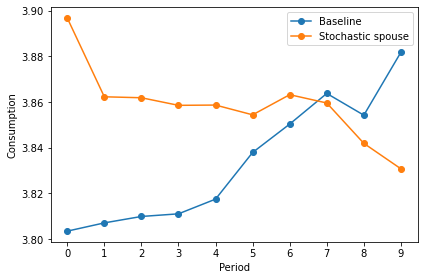

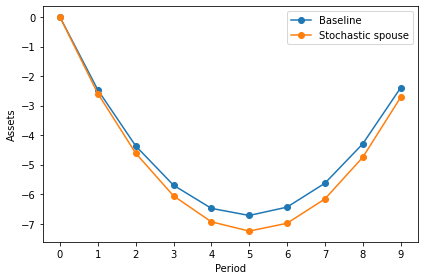

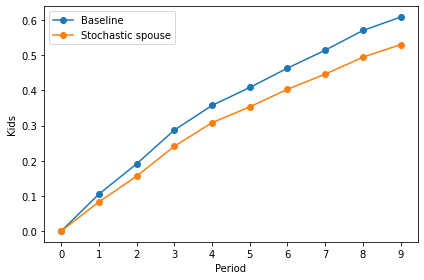

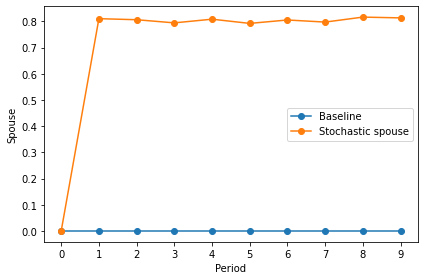

In [28]:
# 6.7) Plot variables
periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.plot(periods, model1_hours, label='Baseline',marker='o')
ax.plot(periods, model2_hours, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.plot(periods, ela_M, label='Baseline',marker='o')
ax.plot(periods, ela_M_ss, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Marshall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.plot(periods, model1_cons, label='Baseline',marker='o')
ax.plot(periods, model2_cons, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.plot(periods, model1_assets, label='Baseline',marker='o')
ax.plot(periods, model2_assets, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.plot(periods, model1_kids, label='Baseline',marker='o')
ax.plot(periods, model2_kids, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Kids', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/kids_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.plot(periods, model1_spouse, label='Baseline',marker='o')
ax.plot(periods, model2_spouse, label='Stochastic spouse',marker='o')
ax.set(xlabel='Period', ylabel='Spouse', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/spouse_6.pdf",edgecolor='k')

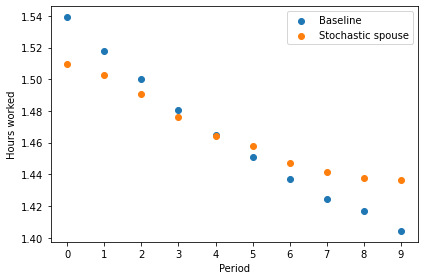

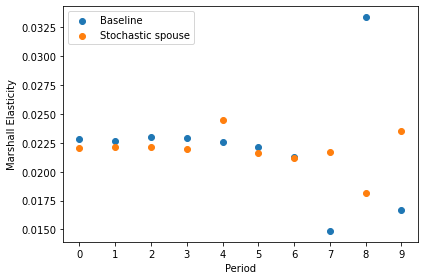

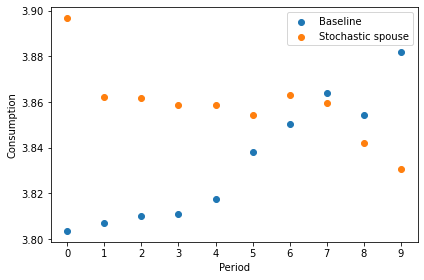

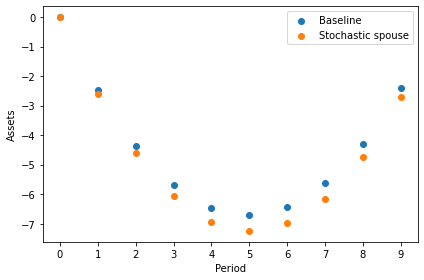

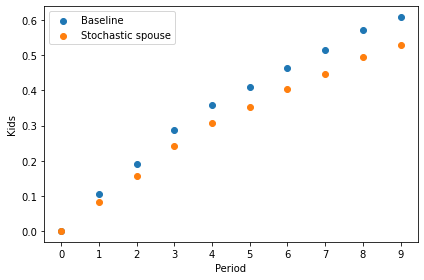

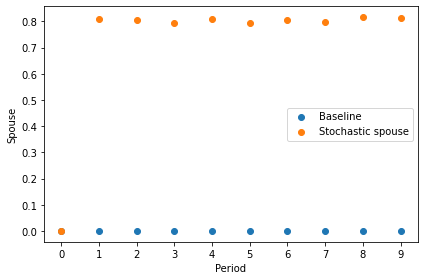

In [29]:
# 6.7) Plot variables
periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.scatter(periods, model1_hours, label='Baseline')
ax.scatter(periods, model2_hours, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M, label='Baseline')
ax.scatter(periods, ela_M_ss, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Marshall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_cons, label='Baseline')
ax.scatter(periods, model2_cons, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_assets, label='Baseline')
ax.scatter(periods, model2_assets, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_kids, label='Baseline')
ax.scatter(periods, model2_kids, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Kids', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/kids_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_spouse, label='Baseline')
ax.scatter(periods, model2_spouse, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Spouse', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/spouse_6.pdf",edgecolor='k')